# Unsupervised Learning on Country Development Data

This notebook applies unsupervised learning techniques to a country-level development dataset.  
Each row represents a country, described by socio-economic and health-related indicators such as child mortality, exports, health expenditure, imports, income, inflation, life expectancy, fertility rate, and GDP per capita.

We treat `country` as an identifier and use the remaining numeric variables as features describing each country's development profile.

## Objectives

In this notebook, we will:

1. **Perform data understanding and EDA**
   - Inspect data structure, types, missing values, and basic statistics.
   - Explore univariate distributions and bivariate relationships.
   - Examine correlations between indicators.

2. **Prepare the data for unsupervised learning**
   - Select numeric features.
   - Standardize variables for fair comparison and clustering.

3. **Build and compare three unsupervised approaches**
   - K-Means clustering on the full standardized feature space.
   - Gaussian Mixture Models (GMM) as a probabilistic clustering approach.
   - PCA-based dimensionality reduction followed by K-Means clustering.

4. **Evaluate and compare the approaches**
   - Use metrics such as inertia, silhouette score, Davies–Bouldin index, and Calinski–Harabasz score.
   - For GMM, add information criteria (AIC, BIC).
   - Visualize cluster structures using PCA-based 2D plots.

5. **Select the most suitable approach and derive insights**
   - Choose a final clustering solution based on metrics and interpretability.
   - Profile clusters in human-readable terms (e.g., high-income vs low-income, high vs low child mortality).
   - Export the final clustered dataset for downstream analysis or policy insights.


# Load Required Libraries

In [16]:
# Import essential data science libraries:
# - numpy: For numerical operations and array manipulation
# - pandas: For data manipulation and analysis using DataFrames
# - matplotlib.pyplot: For creating static visualisations
# - seaborn: For enhanced statistical visualisations built on matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
# Import the StandardScaler for feature normalization
# This scales features to have zero mean and unit variance
from sklearn.preprocessing import StandardScaler
# Import the KMeans clustering algorithm from scikit-learn's cluster module
# KMeans is used for partitioning data into k clusters where each observation belongs to the cluster with the nearest mean
from sklearn.cluster import KMeans
import plotly.express as px  # Import Plotly Express for interactive visualizations




# Suppress all warning messages to keep output clean
# This ignores any warnings that might be generated during code execution
import warnings
warnings.filterwarnings("ignore")

## 2. Data Loading

In this section, we load the dataset from the CSV file available in the working directory (`Country-data.csv`) and perform initial inspections:

- Preview the first few rows.
- Check the dataset shape (number of rows and columns).


In [17]:
# Read the country data from a CSV file into a pandas DataFrame
data = pd.read_csv("Country-data.csv")

## 3. Initial Data Overview

Below is a brief data dictionary describing each column in the dataset in user-friendly terms:

- `country`: Country name (string, identifier; **not used as a feature**).
- `child_mort`: Child mortality rate – under-5 deaths per 1000 live births.
- `exports`: Exports as a percentage of GDP.
- `health`: Health expenditure as a percentage of GDP.
- `imports`: Imports as a percentage of GDP.
- `income`: Net income per person.
- `inflation`: Annual inflation percentage.
- `life_expec`: Life expectancy in years.
- `total_fer`: Total fertility rate (average number of children per woman).
- `gdpp`: GDP per capita.

We will treat `country` as an identifier and focus on the remaining numeric columns as features for unsupervised learning.
Next, we inspect data types, missing values, and basic statistics to build an initial understanding of the dataset.


In [18]:
# Display the first few rows of the dataframe to inspect its structure and content
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [19]:
# Display concise summary of the DataFrame 'data'
# Shows information about index dtype and column dtypes, non-null values and memory usage
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [20]:
# Get the dimensions of the 'data' DataFrame or array
# Returns a tuple with (number of rows, number of columns)
data.shape

(167, 10)

In [21]:
# Calculate summary statistics for all numeric columns in the dataframe
# Transpose the result to display features as rows and statistics as columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


In [22]:
# Transpose the descriptive statistics for object (string) columns in the dataset
# This shows count, unique values, top (most frequent) value, and frequency of the top value
data.describe(include = "object").T

,count,unique,top,freq
country,167,167,Afghanistan,1


In [23]:
# Get the column names of the DataFrame 'data'
data.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [24]:
# Count the number of unique countries in the 'country' column of the dataframe
data["country"].nunique()

167

## 4. Data Quality Checks

Before modeling, we need to ensure the data quality is acceptable:

- **Missing values**: Are there any null entries?
- **Duplicates**: Are there duplicate rows that should be removed?
- **Outliers (overview)**: Are there extreme values that may heavily influence clustering?

We will:
1. Check for missing values and duplicates.
2. Get a quick overview of outliers in numeric features using the interquartile range (IQR) method.


In [25]:
# Check the number of missing values in each column of the dataframe
data.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [26]:
# Check how many duplicate rows exist in the dataset by:
# 1. Using .duplicated() to identify duplicate rows (returns boolean Series)
# 2. Using .sum() to count the total number of True values (duplicate rows)
data.duplicated().sum()

0

# 5. Exploratory Data Analysis (EDA)

In this section, we explore the data to understand:

- **Univariate distributions**: How each numeric feature is distributed (e.g., skewness, range).
- **Bivariate relationships and correlations**: How features relate to each other.
- **High-level patterns**: Potential clusters or separations in the data that may influence our modeling.

### 5.1 Univariate Analysis

We start by examining the distribution of each numeric variable.


### 5.2 Bivariate Analysis and Correlation Structure

Next, we look at pairwise relationships between features and their correlation structure:

- A **correlation matrix** to identify strongly related indicators.
- **Pair plots** for a subset of key variables to visually inspect relationships and potential cluster structures.


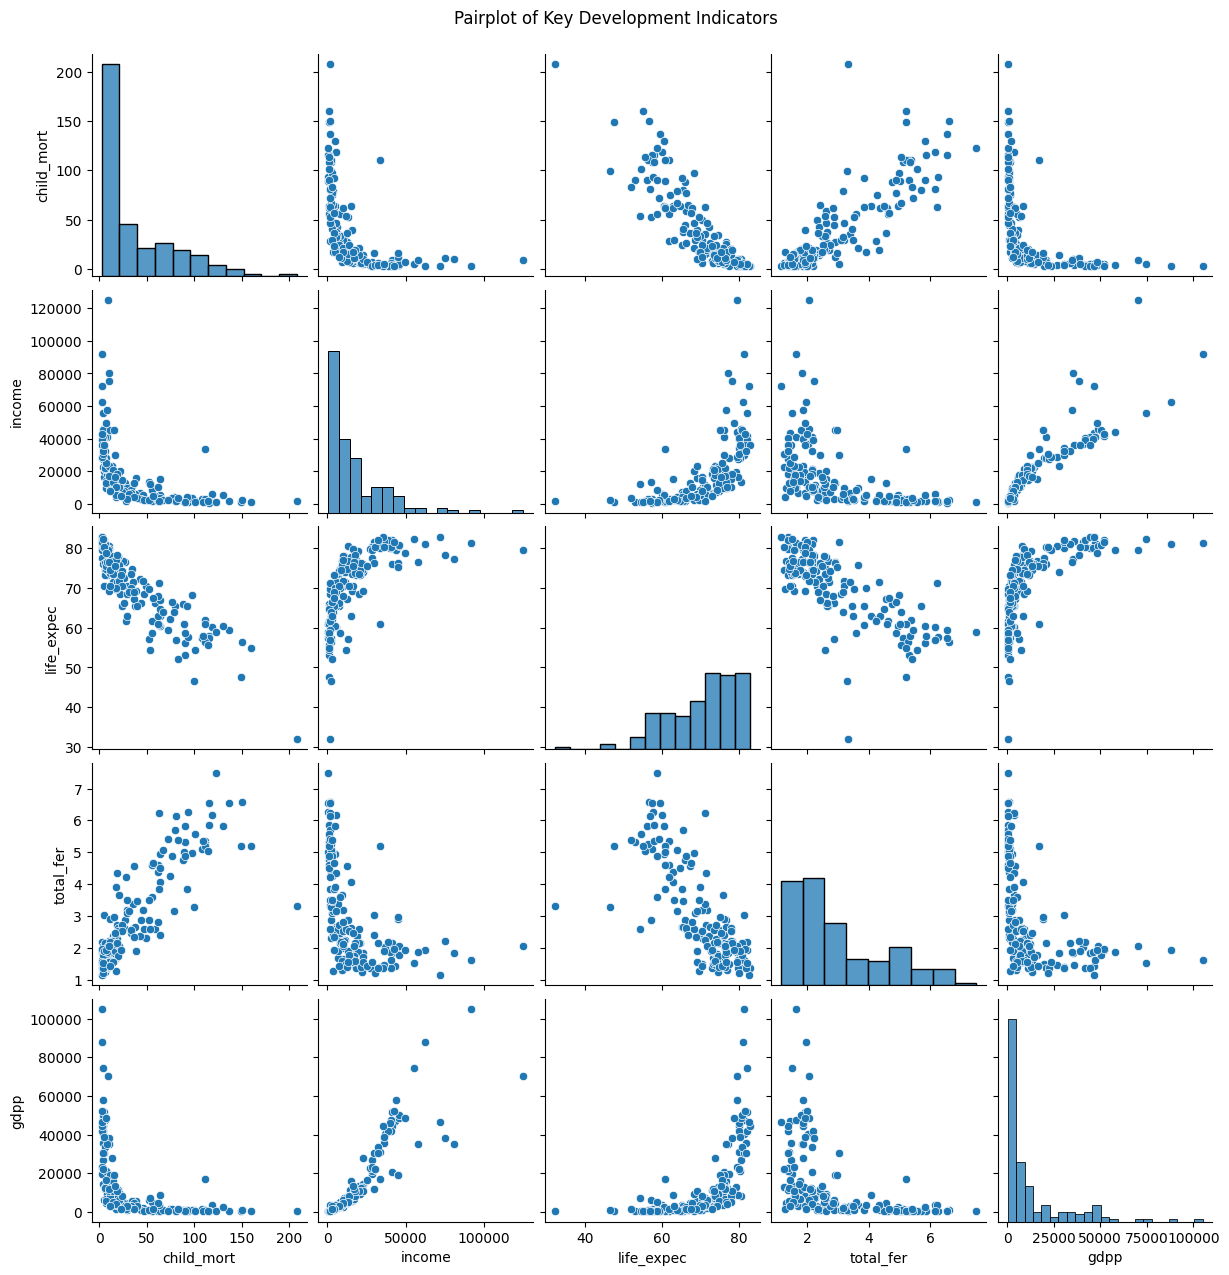

In [34]:
# Create pairplots for key variables to explore relationships and potential cluster structure.

# Select the most important variables for analysis
key_vars = ["child_mort", "income", "life_expec", "total_fer", "gdpp"]

# Generate a matrix of scatterplots showing relationships between all pairs of variables
# Each point represents a country, allowing us to visually identify patterns and correlations
sns.pairplot(data[key_vars])

# Add a title to the entire pairplot figure
# y=1.02 positions the title slightly above the plot to avoid overlap
plt.suptitle("Pairplot of Key Development Indicators", y=1.02)

# Display the plot
plt.show()

##### Categorical- Numerical Bivariate

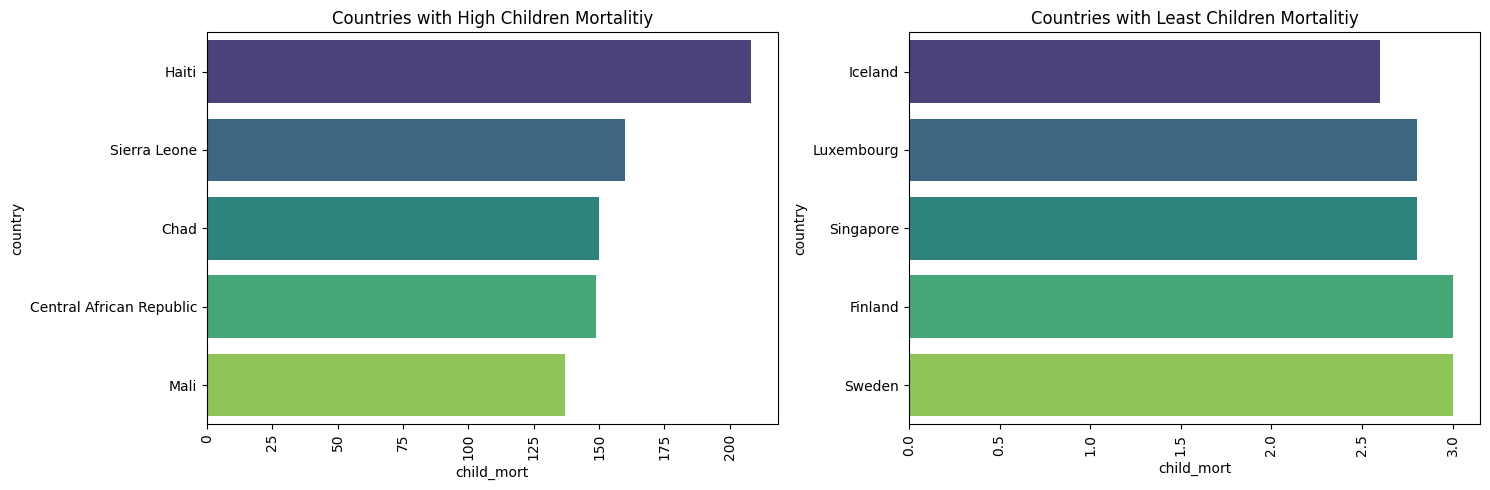

In [32]:
# Sort data to find countries with highest child mortality rates and select top 5
top_five_child_mort = data.sort_values(by='child_mort', ascending=False)[:5]
# Sort data to find countries with lowest child mortality rates and select top 5
least_five_child_mort = data.sort_values(by='child_mort')[:5]

# Create a figure with specified size
plt.figure(figsize=(15, 5))
# Create first subplot for highest child mortality countries
plt.subplot(1,2,1)
# Create horizontal bar plot for countries with highest child mortality
sns.barplot(x='child_mort', y='country', data=top_five_child_mort, orient='h', palette='viridis')
plt.title('Countries with High Children Mortalitiy')
plt.xticks(rotation=90)

# Create second subplot for lowest child mortality countries
plt.subplot(1,2,2)
# Create horizontal bar plot for countries with lowest child mortality
sns.barplot(x='child_mort', y='country', data=least_five_child_mort, orient='h', palette='viridis')
plt.title('Countries with Least Children Mortalitiy')
plt.xticks(rotation=90)

# Adjust layout to prevent overlap between subplots
plt.tight_layout()
# Display the figure with both subplots
plt.show()

# Multivariate Analysis

### Correlation Analysis

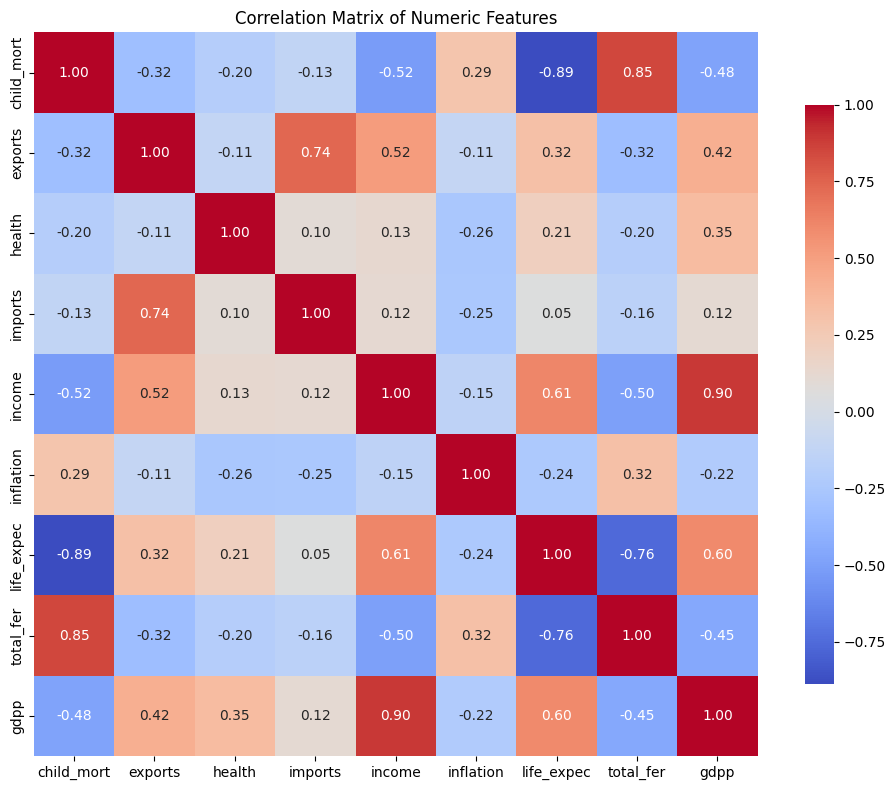

In [33]:
# Get a list of all numeric column names (integer and float types)
numeric_cols = data.select_dtypes(include=['int', 'float']).columns.to_list()
numeric_cols
# Compute and visualize the correlation matrix to understand how features relate.
# numeric_cols = data.select_dtypes(include=['int', 'float'])

# Calculate the correlation matrix for all numeric columns
corr_matrix = data[numeric_cols].corr()

# Create a larger figure for better readability
plt.figure(figsize=(10, 8))
# Generate a heatmap visualization of the correlation matrix
sns.heatmap(
    corr_matrix,
    annot=True,        # Show correlation values in each cell
    fmt=".2f",         # Format numbers to 2 decimal places
    cmap="coolwarm",   # Use a color gradient from cool to warm colors
    square=True,       # Make cells square-shaped
    cbar_kws={"shrink": 0.8}  # Adjust the size of the color bar
)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()     # Adjust spacing for better layout
plt.show()             # Display the heatmap

# Feature Engineering 

##### **Health Metric**
- Child Mortality (life_expect) High values are positive indicators of health. 

In [35]:
new_data = pd.DataFrame()

In [36]:
new_data

""


In [41]:
new_data["Health"] = ((data["life_expec"]/data["life_expec"].mean())  # Normalized life expectancy
                       + (data["health"]/data["health"].mean())        # Normalized health score
                       - (data["child_mort"]/data["child_mort"].mean())  # Normalized child mortality (subtracted as it's negative for health)
                       - (data["total_fer"]/data["total_fer"].mean())    # Normalized fertility rate (subtracted as it's negative for health)
                     )  # Closing parenthesis for the entire expression

##### **Finance Metric**

In [42]:
# Calculate a composite 'Finance' score by:
# 1. Normalizing income (dividing by mean income)
# 2. Normalizing GDP per capita (dividing by mean GDP)
# 3. Subtracting normalized inflation (since higher inflation is negative)
# Higher values indicate better financial conditions
new_data["Finance"] = ((data["income"]/data["income"].mean()) 
                       + (data["gdpp"]/data["gdpp"].mean()) 
                       - (data["inflation"]/data["inflation"].mean()))

##### **Trade Metric**

In [50]:
# Calculate a composite "Trade" metric by:
# 1. Normalising exports by dividing by the mean export value
# 2. Normalising imports by dividing by the mean import value
# 3. Summing these normalised values to get a relative trade activity indicator
new_data["Trade"] = ((data["exports"]/data["exports"].mean())
                       + (data["imports"]/data["imports"].mean()))

In [54]:
new_data.head()

,Finance,Health,Trade
0,-1.076519,-2.422504,1.200812
1,0.317688,1.048966,1.717580
2,-0.972476,0.002385,1.603752
3,-2.262080,-3.929096,2.430387
4,1.870058,0.981553,2.362940


### Distributions of 3 Metrics

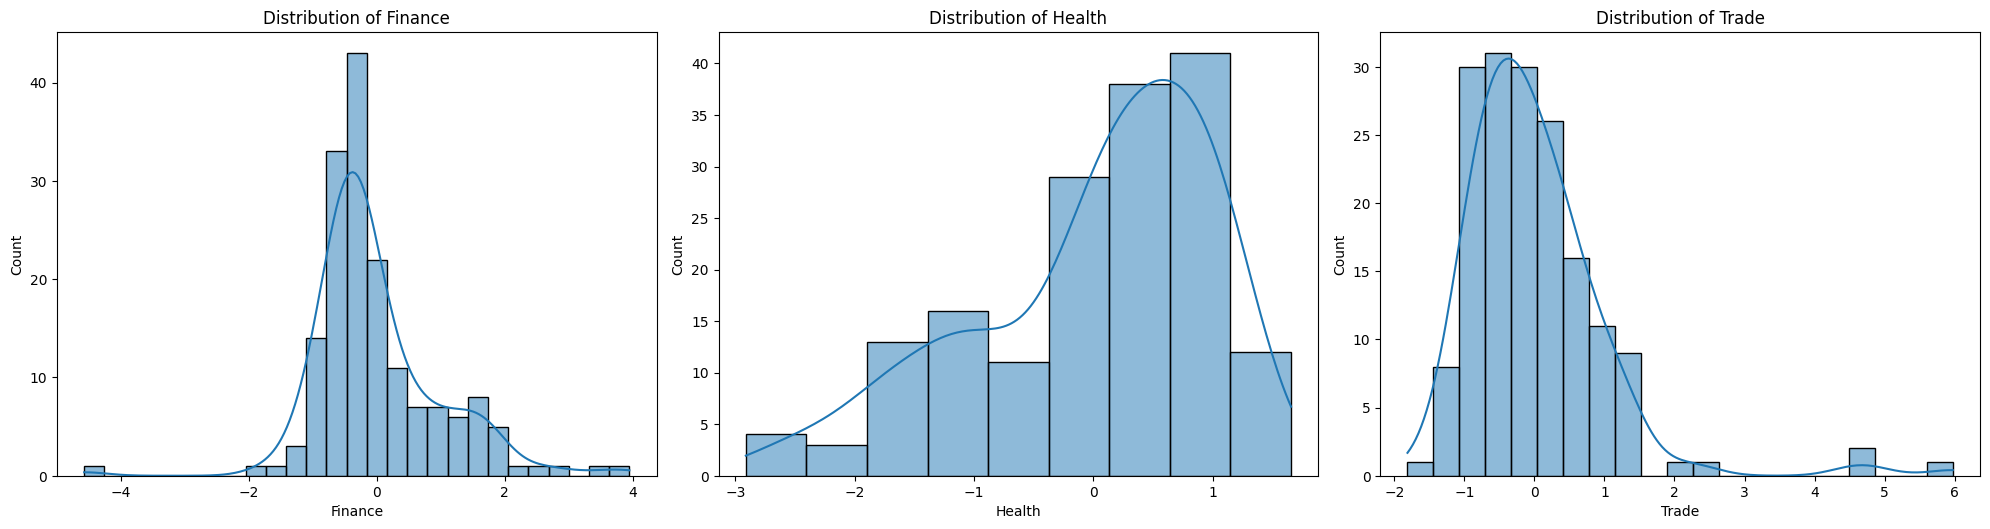

In [61]:
# Plotting distributions for each numerical feature
plt.figure(figsize=(20, 15))  # Create a new figure with specified size (width=20, height=15 inches)

# Loop through each column in the new_data dataframe with enumeration (starting from 1)
for i, column in enumerate(new_data, 1):
    plt.subplot(3, 3, i)  # Create a 3x3 grid of subplots and select the i-th position
    sns.histplot(new_data[column], kde=True)  # Plot histogram with kernel density estimate
    plt.title(f'Distribution of {column}')  # Add title showing which column is being displayed
    
plt.tight_layout()  # Adjust subplot parameters to give specified padding and prevent overlap
plt.show()  # Display all the plots

## 6. Feature Selection and Preprocessing

For unsupervised learning, we will:

- Use all numeric columns except `country` as features.
- Standardize the features using **StandardScaler** so that each has mean 0 and variance 1.
  - This prevents features with larger scales (e.g., income, gdpp) from dominating others.
- Keep the `country` names separately for interpretation and reporting.

We could consider log transformations for highly skewed variables, but to keep this workflow simple and generalizable, we will apply only standardization and note skewness where relevant.


### Scaling the New_Data

In [62]:
# Initialize the StandardScaler for feature normalization
scaler = StandardScaler()
# Standardize the Finance column (zero mean and unit variance)
new_data["Finance"] = scaler.fit_transform(new_data[["Finance"]])
# Standardize the Health column (zero mean and unit variance)
new_data["Health"] = scaler.fit_transform(new_data[["Health"]])
# Standardize the Trade column (zero mean and unit variance)
new_data["Trade"] = scaler.fit_transform(new_data[["Trade"]])

## 7. Approach 1 – K-Means Clustering

K-Means is a popular partitioning clustering algorithm that:

- Assigns each point to one of *k* clusters.
- Minimizes the within-cluster sum of squares (inertia).

We will:

1. Evaluate K-Means for a range of cluster counts (k = 2 to 10).
2. Compute:
   - Inertia (within-cluster sum of squares).
   - Silhouette score.
   - Davies–Bouldin index.
   - Calinski–Harabasz score.
3. Use these metrics and visualizations (elbow curve, metric trends) to select an appropriate number of clusters.
4. Fit a final K-Means model and profile the resulting clusters.


In [68]:
wcss

[501.0,
 315.7629297973318,
 234.43192976623334,
 164.57984219404105,
 132.30890246233832,
 117.73676681687806,
 103.4597304900273,
 91.2591106585502,
 79.70670023544469,
 71.59791029810341]

In [82]:
# Create a KMeans model with 3 clusters
# random_state ensures reproducible results
# n_init=10 runs the algorithm 10 times with different initializations
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Fit the KMeans model to the dataset
kmeans.fit(new_data)


KMeans(n_clusters=3, n_init=10, random_state=42)

In [71]:
data["Class"] = kmeans.labels_
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Class
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


In [72]:
data["Class"].value_counts()

Class
0    84
1    42
2    41
Name: count, dtype: int64

### 7.1 Choosing the Number of Clusters for K-Means

To pick an appropriate number of clusters (*k*), we consider:

- The **elbow** in the inertia curve (diminishing returns after a certain k).
- A **high silhouette score** (closer to 1).
- A **low Davies–Bouldin index**.
- A **high Calinski–Harabasz score**.

For reproducibility and automation, we will select the k that maximizes the silhouette score,
and then briefly inspect it. In practice, you might also visually inspect the elbow curve and metrics to confirm.


#### Elbow

In [73]:
# List to store Within-Cluster Sum of Squares (WCSS) for each k
wcss = []

# Try different numbers of clusters from 1 to 10
for i in range(1, 11):
    
    # Create a KMeans model with 'i' clusters
    # random_state ensures consistent results across runs
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    
    # Fit the model to the data
    kmeans.fit(new_data)
    
    # Store the inertia (WCSS) value for this number of clusters
    wcss.append(kmeans.inertia_)


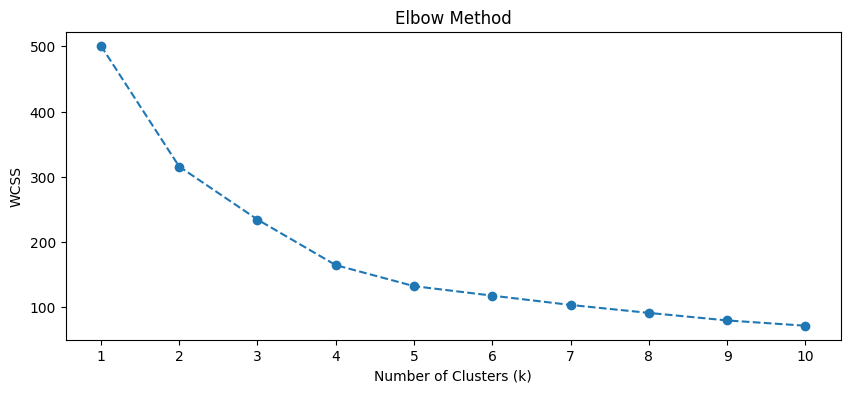

In [74]:
# Plot the Elbow curve to help determine the optimal number of clusters
plt.figure(figsize=(10, 4))  # Set the size of the plot

# Plot WCSS values for k = 1 to 10
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')

plt.title('Elbow Method')  # Title of the plot
plt.xlabel('Number of Clusters (k)')  # Label for the x-axis
plt.ylabel('WCSS')  # Label for the y-axis

plt.xticks(range(1, 11))  # Set x-axis ticks to show 1–10 clearly
plt.show()  # Display the Elbow curve plot

In [76]:
# Create a KMeans model with 3 clusters
# random_state ensures reproducible results
# n_init=10 runs the algorithm 10 times with different initializations
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Fit the KMeans model to the dataset
kmeans.fit(new_data)

KMeans(n_clusters=3, n_init=10, random_state=42)

#### Visualisation of Clusters

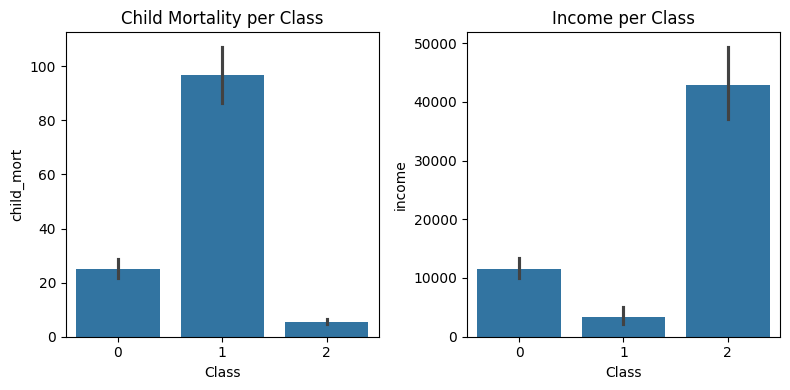

In [78]:
# Create a figure with a size of 8x4 inches
plt.figure(figsize=(8, 4))

# First subplot: Child mortality per class 
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sns.barplot(x='Class', y='child_mort', data=data)  # Bar plot for child mortality by class
plt.title('Child Mortality per Class')  # Title for the first plot

# Second subplot: Income per class ----
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
sns.barplot(x='Class', y='income', data=data)  # Bar plot for income by class
plt.title('Income per Class')  # Title for the second plot

# Adjust spacing between subplots for a cleaner layout
plt.tight_layout()

# Display the plots
plt.show()


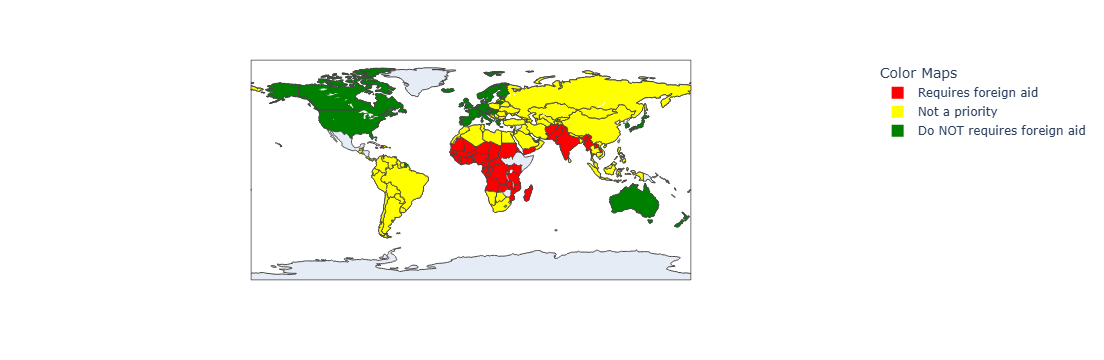

In [81]:
# Replace numeric class labels with meaningful category names
data['Class'] = data['Class'].replace({
    0: "Not a priority",
    1: "Requires foreign aid",
    2: "Do NOT require foreign aid"
})

# Create a choropleth world map using Plotly
fig = px.choropleth(
    data[['country', 'Class']],        # Use only the country and class columns
    locationmode='country names',      # Plotly should interpret locations as country names
    locations='country',               # Column containing country names
    color=data['Class'],               # Color countries based on the 'Class' category
    color_discrete_map={               # Assign custom colours to each category
        'Requires foreign aid': 'Red',
        'Do NOT require foreign aid': 'Green',
        'Not a priority': 'Yellow'
    }
)

# Update layout: customise legend title
fig.update_layout(legend_title_text='Color Maps')

# Display the interactive choropleth map
fig.show()


## 8. Approach 2 – Gaussian Mixture Models (GMM)

Gaussian Mixture Models (GMM) provide a **probabilistic** approach to clustering:

- Model the data as a mixture of multiple Gaussian distributions.
- Allow clusters to be **elliptical** and have different sizes/densities.
- Assign **probabilities** of belonging to each cluster (soft clustering).

We will:

1. Vary the number of components (clusters) from 2 to 10.
2. For each model, compute:
   - BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion).
   - Silhouette score.
   - Davies–Bouldin index.
   - Calinski–Harabasz score.
3. Choose the number of components based on information criteria (lower is better) and clustering metrics.
4. Fit a final GMM and profile the resulting clusters.


### 8.1 Choosing the Number of Components for GMM

To choose the number of mixture components, we consider:

- **Lowest BIC and AIC** values (penalize model complexity).
- **Higher silhouette score**.
- **Lower Davies–Bouldin index**.
- **Higher Calinski–Harabasz score**.

We will select the number of components that minimizes the BIC, and then check that clustering metrics are reasonable.


In [ ]:
# Fit the chosen GMM model and add GMM cluster labels to the dataframe.

# Choose n_components that minimizes BIC
final_n_components = int(gmm_eval_df.loc[gmm_eval_df["bic"].idxmin(), "n_components"])
print(f"Chosen number of components for GMM based on BIC: {final_n_components}")

gmm_final = GaussianMixture(
    n_components=final_n_components,
    covariance_type="full",
    random_state=RANDOM_STATE
)
gmm_final.fit(X_scaled)
gmm_labels = gmm_final.predict(X_scaled)

# Optionally get cluster membership probabilities
gmm_probs = gmm_final.predict_proba(X_scaled)

# Add GMM cluster labels to the dataframe
data["cluster_gmm"] = gmm_labels

print("\nCluster size distribution (GMM):")
display(data["cluster_gmm"].value_counts().sort_index())


## 9. Approach 3 – PCA-Based Dimensionality Reduction and Clustering

In this approach:

1. **PCA (Principal Component Analysis)** is used to reduce dimensionality:
   - Capture most of the variance in fewer components.
   - Potentially denoise the data and expose clearer cluster structure.
2. We inspect the **explained variance** to decide how many principal components to keep.
3. We run **K-Means clustering** on the PCA-reduced features and evaluate clustering quality.
4. We visualize clusters in PCA space and compare with previous approaches.


## 10. Model Comparison and Selection

We now compare the three main approaches:

1. **K-Means on full standardized feature space** (`cluster_kmeans`).
2. **GMM on full standardized feature space** (`cluster_gmm`).
3. **K-Means on PCA-reduced features** (`cluster_pca_kmeans`).

For each final model, we compute:

- Silhouette score.
- Davies–Bouldin index.
- Calinski–Harabasz score.
- (For GMM) BIC and AIC of the final model.

We then summarize and select a “best overall” approach, balancing:

- Quantitative metrics.
- Interpretability of clusters.
- Stability and simplicity.


### 10.1 Narrative Comparison

Based on the metrics:

- **Silhouette score** (higher is better) indicates how well-separated clusters are.
- **Davies–Bouldin index** (lower is better) captures cluster separation/compactness.
- **Calinski–Harabasz score** (higher is better) measures between-cluster vs within-cluster dispersion.
- **BIC/AIC for GMM** (lower is better) capture model fit vs complexity.

Typical reasoning to choose a final model:

- Prefer the model with **higher silhouette** and **Calinski–Harabasz**, and **lower Davies–Bouldin**.
- If the PCA-based model shows comparable or better metrics, it may also offer:
  - Reduced dimensionality (simpler representation).
  - Potentially cleaner cluster structure.

In the next cell, we will automatically select the “best” model based on the highest silhouette score, then use it for final insights and export. In practice, you would also inspect the profiles and decide if the clusters make intuitive sense.


## 11. Final Insights and Export

With the final clustering model selected (`cluster_final`), we now:

1. **Profile clusters** to understand their development characteristics:
   - Average child mortality, income, life expectancy, fertility rates, GDP per capita, etc.
2. **Interpret clusters** in human-readable terms (e.g., "high-income, low-mortality" vs "low-income, high-mortality").
3. **Export results** to a CSV file for downstream analysis or policy use.

These insights can help:

- Policymakers identify groups of countries with similar development challenges.
- International organizations prioritize interventions.
- Analysts explore patterns across socio-economic dimensions.
